In [1]:
%load_ext autoreload
%autoreload 2

import ccxt
import time
import matplotlib.pyplot as plt

In [23]:
# mlflowの設定
import mlflow

mlflow.set_tracking_uri('http://mlflow:8890')
mlflow.set_experiment('crypto_portfolio_bot')

# 実験のパラメータ
experiment_options = {
    'objective_type': 'efficient_risk',
    'objective_param': 0.2,
    'download_timebar': False,
    'calculate_topx': False,
    'l2_reg': True,
    'l2_reg_gamma': 0.02,
    'weight_upper_bound': 1,            # 1銘柄のポジション / 全ポジションの絶対値の合計の最大値
    'weight_lower_bound': -1,           # 1銘柄のポジション / 全ポジションの絶対値の合計の最小値
    'rebalance_interval': 2*60*60,      # ポートフォリオリバランス間隔 [秒]
    'execution_period': 1.5*60*60,      # ポートフォリオリバランス実行期間 [秒]
    'timebar_interval': 5*60,           # タイムバー間隔 [秒]
    'weight_calc_period': 30*24*60*60,  # ポートフォリオ計算時のリターン系列の長さ [秒]
    'execution_cost': 0.001,            # トレード手数料
}

mlflow.end_run()
mlflow.log_dict(experiment_options, 'experiment_optios.json')

for _idx, _value in enumerate(experiment_options):
    print(f'{_value} {experiment_options[_value]}')
    mlflow.log_param(_value, experiment_options[_value])

objective_type efficient_risk
objective_param 0.2
download_timebar False
calculate_topx False
l2_reg True
l2_reg_gamma 0.02
weight_upper_bound 1
weight_lower_bound -1
rebalance_interval 7200
execution_period 5400.0
timebar_interval 300
weight_calc_period 2592000
execution_cost 0.001


In [3]:
# 時間足データを保存する時に使うTimescaleDB用のユーティリティライブラリの設定

import os
from timescaledb_util import *

pg_config = {
    'user': os.environ['POSTGRES_USER'],
    'password': os.environ['POSTGRES_PASSWORD'],
    'host': os.environ['POSTGRES_HOST'],
    'port': os.environ['POSTGRES_PORT'],
    'database': os.environ['POSTGRES_DATABASE_OHLCV_TRADES']
}

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
dbutil = TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])

In [4]:
from decimal import Decimal
from datetime import timezone, datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option("display.max_rows", 50)
pd.set_option("display.min_rows", 50)
idxslice = pd.IndexSlice

# タイムバーをダウンロードしてTimescaleDBに保存する関数、所定のdict型の配列でダウンロード対象を指定する
def download_timebar(targets):
    for target in targets:
        _exchange = target['exchange']
        _ccxt_client = getattr(ccxt, _exchange)()
        _ccxt_client.load_markets()

        _symbol = target['symbol']
        _interval = target['interval']
        
        since = int(time.mktime(datetime.strptime('2019-01-01 00:00:00+0000', '%Y-%m-%d %H:%M:%S%z').timetuple()) * 1000)

        dbutil.init_timebar_table(_exchange, _symbol, _interval)
        table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)

        df = dbutil.get_latest_timebar(_exchange, _symbol, _interval)
        if type(df) != type(None):
            latest_datetime = df['datetime']
            latest_timestamp = int(latest_datetime.timestamp() * 1000) + 1

            if latest_timestamp > since:
                since = latest_timestamp

        till = int(datetime.now(tz = timezone.utc).timestamp() * 1000)
        origin = since

        with tqdm(total = int(till - origin), initial=0) as _pbar:
            _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: 0')
            while since <= till:
                time.sleep(ccxt_client.rateLimit / 1000)

                result = ccxt_client.fetch_ohlcv(_symbol, _interval, since = int(since), limit = 1000) # 5min

                df = pd.DataFrame.from_dict(result, dtype=str)
                if len(df) == 0:
                    break

                _to_decimal = lambda x: Decimal(x)

                df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
                df['datetime'] = df['datetime'].apply(lambda x: datetime.fromtimestamp(float(x) / 1000, tz = timezone.utc))
                df['datetime_from'] = df['datetime'] - timedelta(seconds=300) - timedelta(microseconds=1)
                df['open'] = df['open'].apply(_to_decimal)
                df['high'] = df['high'].apply(_to_decimal)
                df['low'] = df['low'].apply(_to_decimal)
                df['close'] = df['close'].apply(_to_decimal)
                df['volume'] = df['volume'].apply(_to_decimal)

                nan_columns = ['id', 'id_from', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum', 'dollar_buy_cumsum', 'dollar_sell_cumsum']
                for column in nan_columns:
                    df[column] = Decimal(0)

                ret = dbutil.df_to_sql(df=df, schema = table_name, if_exists = 'append')

                since = int(df.iloc[-1]['datetime'].timestamp()*1000) + 1
                _pbar.n = since - origin
                _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: {len(df)}')
                _pbar.refresh()
            
            _pbar.n = int(till - origin)
            _pbar.refresh()

            

In [5]:
# CCXTのクライアントを作り、無期限先物市場の5分足情報をTimescaleDBに書き込む

if experiment_options['download_timebar'] == True:
    # USDT建ての無期限先物を時間足ダウンロードの対象として設定する
    ccxt_client = getattr(ccxt, 'binanceusdm')()
    ccxt_client.load_markets()

    targets = []
    for symbol in ccxt_client.symbols:
        if '/USDT' in symbol:
            target_5m = {
                'exchange': 'binanceusdm',
                'symbol': symbol,
                'interval': f'{experiment_options["timebar_interval"]/60:.0f}m'
            }
            targets.append(target_5m)

    # USDT建ての無期限先物の5分足をTimescaleDBにダウンロードする
    download_timebar(targets)

In [6]:
# ダウンロードした無期限先物の直近50000本分の取引ボリュームを概算する

if experiment_options['calculate_topx'] == True:
    result = []
    row_counts = 0

    with tqdm(total = len(targets), initial=0) as _pbar:
        for target in targets:
            _exchange = target['exchange']
            _symbol = target['symbol']
            _interval = target['interval']

            table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)
            df = dbutil.read_sql_query(f'SELECT open, close, volume from "{table_name}"')
            recent_dollar_volume = (df.iloc[-50000:]['volume'] * (df.iloc[-50000:]['close'] + df.iloc[-50000:]['open']) / 2).sum()
            result.append({'symbol': _symbol, 'rows': len(df), 'recent_dollar_volume': recent_dollar_volume})

            row_counts = row_counts + len(df)
            _pbar.n = _pbar.n + 1
            _pbar.set_postfix_str(f'{_symbol}, row_counts: {row_counts:,}, recent_dollar_volume: {recent_dollar_volume:,}')
            _pbar.refresh()

    df_recent_volume = pd.DataFrame(result)
    
    # 取引ボリューム概算結果を表示する
    df_recent_volume = df_recent_volume.sort_values('recent_dollar_volume', ascending=False)
    df_recent_volume['listed_days'] = df_recent_volume['rows']*5/60/24
    df_recent_volume = df_recent_volume.reset_index(drop=True)
    display(df_recent_volume[df_recent_volume['listed_days'] > 250])
    
    # 取引ボリューム概算が大きい順に10銘柄でポートフォリオの挙動をテストする
    portfolio_symbols = df_recent_volume[df_recent_volume['listed_days'] > 250].iloc[:10]['symbol']
else:
    portfolio_symbols = ['BTC/USDT', 'ETH/USDT', '1000SHIB/USDT', 'SOL/USDT', 'SAND/USDT', 'LUNA/USDT', 'FTM/USDT', 'XRP/USDT', 'ADA/USDT', 'AVAX/USDT']

print(f'Target symbols are {portfolio_symbols}')

Target symbols are ['BTC/USDT', 'ETH/USDT', '1000SHIB/USDT', 'SOL/USDT', 'SAND/USDT', 'LUNA/USDT', 'FTM/USDT', 'XRP/USDT', 'ADA/USDT', 'AVAX/USDT']


In [7]:
import talib

# ポートフォリオ構成銘柄の価格系列などを準備する
dfs = []
for _symbol in tqdm(portfolio_symbols):
    _table_name = dbutil.get_timebar_table_name('binanceusdm', _symbol, '5m')
    _df = dbutil.read_sql_query(f'SELECT datetime, close from "{_table_name}" WHERE datetime BETWEEN \'2020-01-01 00:00:00+00\' AND \'2023-01-01 00:00:00+00\' ORDER BY datetime ASC', index_column = '')
    _df.loc[:, 'symbol'] = _symbol
    _df.loc[:, 'ret'] = _df.loc[:, 'close'].pct_change()
    _df.loc[:, 'twap'] = talib.SMA(_df.loc[:, 'close'], timeperiod = int(experiment_options['execution_period'] / experiment_options['timebar_interval'])).shift()
    _df.dropna(inplace = True)
    dfs.append(_df)

df_portfolio = pd.concat(dfs).set_index(['datetime', 'symbol']).sort_index()

# ウェイトを入れる列を準備する
df_portfolio['w'] = np.nan
_row_index = df_portfolio.index[0]
df_portfolio.loc[idxslice[_row_index, :], 'w'] = 0.0

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]
/tmp/ipykernel_1639059/3937937862.py:19: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_portfolio.loc[idxslice[_row_index, :], 'w'] = 0.0


In [8]:
# PyPortfolioOptを利用してポートフォリオウェイトを計算

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import plotting

import cvxpy as cp

COV_LENGTH = int(experiment_options['weight_calc_period'] / experiment_options['timebar_interval'])

df_weight_calc = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close')
array_performance = []

for i in tqdm(range(df_weight_calc.shape[0])):
    # リバランスの時間でだけポートフォリオのウェイトを計算する
    if df_weight_calc.index[i].timestamp() % experiment_options['rebalance_interval'] == 0:
        # 十分なリターン系列の長さがない場合は精度が出ないのでウェイト計算を行わない
        if i + 1 < COV_LENGTH:
            continue
        _df_cov = df_weight_calc.iloc[max(0, i - COV_LENGTH + 1):i + 1].dropna(axis=1)
        
        # 構成銘柄が1銘柄しかない場合にはウェイト計算を行わない
        if _df_cov.shape[1] <= 1:
            continue
            
        # ここよりPyPortfolioOptによるポートフォリオウェイト計算
        _mu = mean_historical_return(_df_cov)
        _S = CovarianceShrinkage(_df_cov).ledoit_wolf()
        _ef = EfficientFrontier(_mu, _S, weight_bounds = (experiment_options['weight_lower_bound'], experiment_options['weight_upper_bound']))
        if experiment_options['l2_reg'] == True:
            _ef.add_objective(objective_functions.L2_reg, gamma=experiment_options['l2_reg_gamma']) # L2正則化を入れてひとつの銘柄にウェイトが集中するのを防ぐ
        
        # メモ : 負のポジションを許し、ポジションの絶対値の合計を1以下にするためにpyportfoliooptの_make_weight_sum_constraint関数に変更を加えている
        #def _make_weight_sum_constraint(self, is_market_neutral):
        #    ...
        #    else:
        #        # Check negative bound
        #        negative_possible = np.any(self._lower_bounds < 0)
        #        if negative_possible:
        #            # Use norm1 as position constraint
        #            self.add_constraint(lambda w: cp.sum(cp.abs(w)) <= 1)
        #        else: 
        #            self.add_constraint(lambda w: cp.sum(w) == 1)
        #    self._market_neutral = is_market_neutral
        
        # ウェイトを計算する
        if experiment_options['objective_type'] == 'max_quadratic_utility':
            _weights = _ef.max_quadratic_utility(risk_aversion = experiment_options['objective_param'])
        elif experiment_options['objective_type'] == 'max_sharpe':
            _weights = _ef.max_sharpe()
        elif experiment_options['objective_type'] == 'min_volatility':
            _weights = _ef.min_volatility()
        elif experiment_options['objective_type'] == 'efficient_risk':
            _weights = _ef.efficient_risk(target_volatility = experiment_options['objective_param'])
        
        # ポートフォリオパフォーマンスを記録する
        _return, _volatility, _sharpe = _ef.portfolio_performance()
        array_performance.append([df_weight_calc.index[i], _return, _volatility, _sharpe])
        
        # ウェイトを計算する
        _cleaned_weights = _ef.clean_weights()
        for _key, _value in _cleaned_weights.items():
            df_portfolio.loc[(df_weight_calc.index[i], _key), 'w'] = _value

100%|██████████| 228277/228277 [07:40<00:00, 495.94it/s]


In [9]:
# TWAP returnの計算 : リバランス間隔秒後のタイミングまでにどれだけのリターンがあるかを各銘柄について計算する (現在から未来へのリターンを計算)

# リバランス間隔で行を抜き出す。行のlevel 0 indexはDatetime、level 1 indexは銘柄名
_df_portfolio = df_portfolio.loc[(df_portfolio.index.get_level_values('datetime').astype(np.int64) // 10**9 % experiment_options['rebalance_interval'] == 0), :]

# 行インデックスをDatetime, 列インデックスを銘柄、値をTWAPとしたDataframeを作り、リターンを計算
_df_twap_ret = _df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='twap').dropna(how = 'all')
_df_twap_ret = (_df_twap_ret.shift(-1) / _df_twap_ret - 1.0)

# TWAPリターンを計算した結果を再度スタックし、もとのDataframeに値を代入する
_df_twap_ret = _df_twap_ret.stack()
df_portfolio['twap_ret'] = np.nan
df_portfolio['twap_ret'] = _df_twap_ret
#display(df_portfolio)

In [24]:
# リバランスコストの計算 : リバランス間隔秒前からのポジション変化からリバランスコストを各銘柄について計算する (過去から現在までのコストを計算)
_df_portfolio = df_portfolio.loc[(df_portfolio.index.get_level_values('datetime').astype(np.int64) // 10**9 % experiment_options['rebalance_interval'] == 0), :]

# 行インデックスをDatetime, 列インデックスを銘柄、値をウェイトとしたDataframeを作り、取引コストを計算
_df_cost = _df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='w').dropna(how = 'all')
_df_cost = np.abs(_df_cost.diff()) * experiment_options['execution_cost']

# コストを計算した結果を再度スタックし、もとのDataframeに値を代入する
_df_cost = _df_cost.stack()
df_portfolio['cost'] = np.nan
df_portfolio['cost'] = _df_cost

In [25]:
# リバランスコストを考慮した各銘柄のリターンを計算する
_df_portfolio = df_portfolio.loc[~np.isnan(df_portfolio['twap_ret']) & ~np.isnan(df_portfolio['cost']), :]
df_portfolio['twap_ret_w_cost'] = _df_portfolio['twap_ret'] - _df_portfolio['cost']
#display(df_portfolio.loc[(df_portfolio.index.get_level_values('datetime').astype(np.int64) // 10**9 % experiment_options['rebalance_interval'] == 0) & (df_portfolio.index.get_level_values('datetime') > '2021-01-16 00:00:00+00'), :])

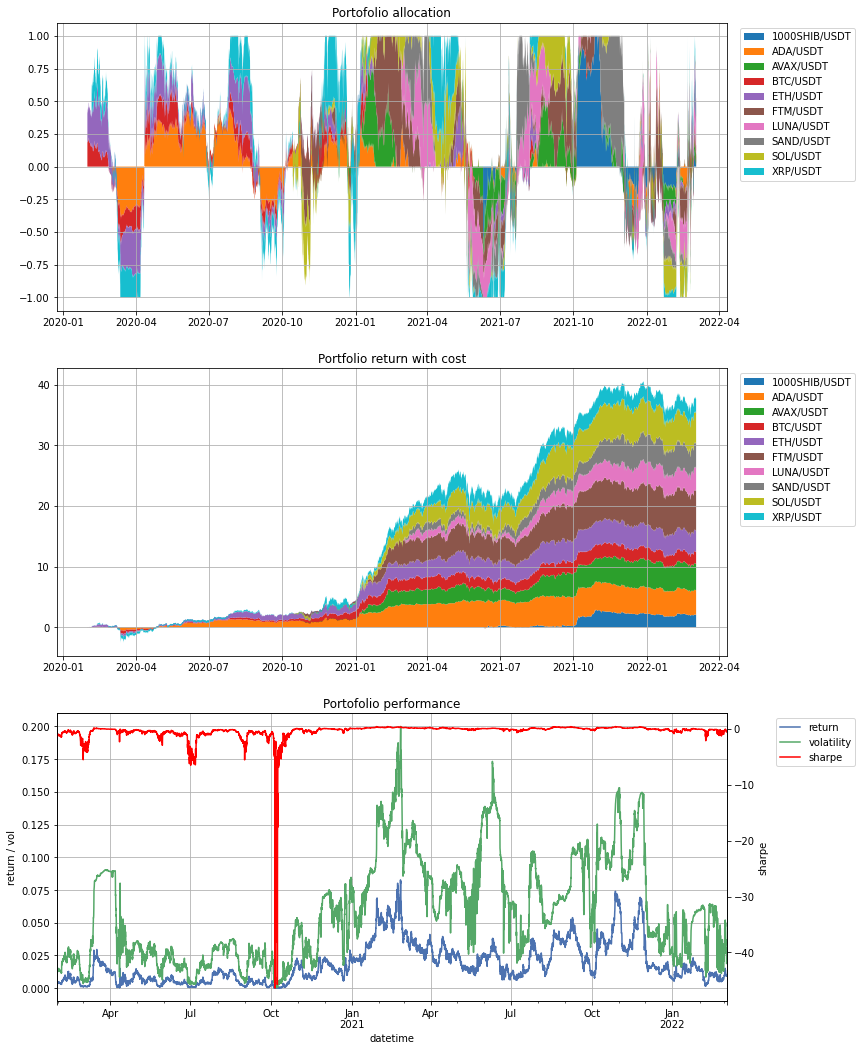

In [26]:
# 表示用のfigureを準備
_render_from = '2020-01-01 00:00:00+00'
_render_to = '2023-01-01 00:00:00+00'

fig, ax = plt.subplots(3, 1, figsize=(12, 18))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# 行のすべてのウェイトが0またはNaNの行を削除してウェイト用のDataFrameを完成させる
df_weight = df_portfolio.loc[(df_portfolio.index.get_level_values('datetime').astype(np.int64) // 10**9 % experiment_options['rebalance_interval'] == 0), :]
df_weight = df_weight.reset_index().pivot(index = 'datetime', columns = 'symbol', values='w').dropna(how = 'all').fillna(0)

# ポートフォリオウェイトの描画
ax[0].stackplot(df_weight[_render_from:_render_to].index, df_weight[_render_from:_render_to].T, colors=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'), labels=df_weight.columns)
handle, label = ax[0].get_legend_handles_labels()
ax[0].grid(True)
ax[0].legend(bbox_to_anchor=(1.2, 1))
ax[0].set_title(f'Portofolio allocation')

# コストを考慮した銘柄リターン表示用のデータフレームを準備
df_twap_ret_cost = df_portfolio.loc[(df_portfolio.index.get_level_values('datetime').astype(np.int64) // 10**9 % experiment_options['rebalance_interval'] == 0), :]
df_twap_ret_cost = df_twap_ret_cost[_render_from:_render_to]

# 行インデックスをDatetime, 列インデックスを銘柄、値をリバランスコストを考慮したリターンとしたDataframeを作る
df_twap_ret_cost = df_twap_ret_cost.reset_index().pivot(index = 'datetime', columns = 'symbol', values='twap_ret_w_cost').dropna(how = 'all')
df_twap_ret_cost = df_twap_ret_cost.cumsum().fillna(0)

ax[1].stackplot(df_twap_ret_cost.index, df_twap_ret_cost.T, colors=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'), labels=df_twap_ret_cost.columns)
ax[1].grid(True)
ax[1].legend(bbox_to_anchor=(1.2, 1))
ax[1].set_title('Portfolio return with cost')

# ポートフォリオ自体のパフォーマンス表示用のデータフレームを準備
df_portfolio_performance = pd.DataFrame(array_performance, columns=['datetime', 'return', 'volatility', 'sharpe']).set_index('datetime', drop = True)

# ポートフォリオ自体のパフォーマンス描画
df_portfolio_performance[_render_from:_render_to]['return'].plot(ax = ax[2], label='return')
df_portfolio_performance[_render_from:_render_to]['volatility'].plot(ax = ax[2], label='volatility')
ax[2].grid(True)
ax_sub = ax[2].twinx()
ax_sub.set_ylabel('sharpe')
df_portfolio_performance[_render_from:_render_to]['sharpe'].plot(ax = ax_sub, style='r-', label='sharpe')
ax[2].set_title(f'Portofolio performance')
ax[2].set_ylabel('return / vol')
handle, label = ax[2].get_legend_handles_labels()
handle2, label2 = ax_sub.get_legend_handles_labels()
ax[2].legend(handle + handle2, label + label2, bbox_to_anchor=(1.2, 1))

mlflow.log_figure(fig, 'portofolio.png')
fig.show()

In [15]:
mlflow.end_run()